In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns


In [2]:
site_group = '5e-4_qval'


In [3]:
dataset_accuracies = pd.read_csv('../../MBC_validation/validation_analysis/validation_results/'+site_group+'.dataset_accuracies.txt',sep='\t', header = [0,1])

probabilities = pd.read_csv('../../MBC_validation/validation_analysis/validation_results/'+site_group+'.probabilities.txt',sep='\t')


In [4]:
dataset_accuracies.head()

BRCA_Ghana_ULP                                MBC_Dawson_downsampled  \
    0.05-0.1_TFx <0.05_TFx >0.1_TFx All samples           0.05-0.1_TFx   
0            1.0     0.000      1.0    0.642857                    1.0   
1            1.0     0.700      1.0    0.785714                    1.0   
2            1.0     0.500      1.0    0.714286                    1.0   
3            1.0     0.700      1.0    0.785714                    1.0   
4            1.0     0.625      1.0    0.785714                    1.0   

                                   MBC_Stover                                  
  <0.05_TFx >0.1_TFx All samples 0.05-0.1_TFx <0.05_TFx  >0.1_TFx All samples  
0  0.631579      1.0    0.740741     0.700000  0.166667  1.000000    0.566667  
1  0.785714      1.0    0.888889     1.000000  0.285714  1.000000    0.666667  
2  0.500000      1.0    0.777778     0.777778  0.100000  0.727273    0.533333  
3  0.750000      1.0    0.888889     0.500000  0.600000  1.000000    0.766667  
4  0.666667      1.0    0.851852     0.750000  0.461538  1.000000    0.700000

In [5]:
boxplot_data = pd.DataFrame(dataset_accuracies.unstack())
boxplot_data = boxplot_data.reset_index()
boxplot_data = boxplot_data.rename(columns = {0:'accuracy','level_0':'dataset','level_1':'group','level_2':'iteration'})


In [6]:
boxplot_data.head()

,dataset,group,iteration,accuracy
0,BRCA_Ghana_ULP,0.05-0.1_TFx,0,1.0
1,BRCA_Ghana_ULP,0.05-0.1_TFx,1,1.0
2,BRCA_Ghana_ULP,0.05-0.1_TFx,2,1.0
3,BRCA_Ghana_ULP,0.05-0.1_TFx,3,1.0
4,BRCA_Ghana_ULP,0.05-0.1_TFx,4,1.0


In [7]:
boxplot_data['dataset'].unique()

array(['BRCA_Ghana_ULP', 'MBC_Dawson_downsampled', 'MBC_Stover'],
      dtype=object)

In [8]:
#https://github.com/mwaskom/seaborn/issues/1076
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if len(l.get_xdata())==2 and np.all(l.get_xdata() == [xmin, xmax]): #modified to prevent element wise comparison failure
                        l.set_xdata([xmin_new, xmax_new])


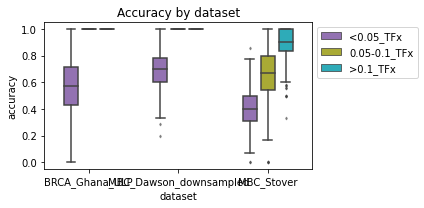

In [9]:
fig,ax = plt.subplots(figsize = (6,3))

metric = 'accuracy'
group_order = ['<0.05_TFx','0.05-0.1_TFx', '>0.1_TFx']
dataset_order = ['BRCA_Ghana_ULP', 'MBC_Dawson_downsampled', 'MBC_Stover']
sns.boxplot(x = boxplot_data['dataset'],
            y = boxplot_data[metric],
            hue = boxplot_data['group'],
           width = 0.6,
           order = dataset_order,
            hue_order = group_order,
            palette= ['tab:purple','tab:olive','tab:cyan'],
           ax = ax,
           flierprops = {'markersize':2, 'alpha':0.5})

adjust_box_widths(fig, 0.8)
plt.title('Accuracy by dataset')
plt.legend(bbox_to_anchor = [1,1], loc= 'upper left')
plt.tight_layout()
plt.savefig('plots/validation_set_boxplot.pdf')

In [10]:
probabilities = probabilities[['sample','dataset','tfx_group','status']]

In [11]:
all_metrics_df = pd.DataFrame()

order = ['<0.05_TFx','0.05-0.1_TFx', '>0.1_TFx', 'All samples']

for dataset,test_data in probabilities.groupby('dataset'):
    #get metrics for each dataset dataset
    
    #get status counts for each dataste
    metrics_df = pd.DataFrame(test_data[['tfx_group','status']].value_counts()).unstack()
    metrics_df.columns = metrics_df.columns.droplevel()

    #get overall status counts
    current_dict = test_data['status'].value_counts().to_dict()
    metrics_df = metrics_df.append(pd.Series(current_dict, name = 'All samples'))

    # #reformat for printing
    metrics_df = metrics_df.rename(columns = {1:'ER+ samples',0:'ER- samples'})

    #replace nan with zero
    metrics_df['ER+ samples'] = np.nan_to_num(metrics_df['ER+ samples'])
    
    if not 'ER- samples' in metrics_df.columns:
        metrics_df['ER- samples'] = 0
        
    metrics_df[['ER+ samples','ER- samples']] = metrics_df[['ER+ samples','ER- samples']].astype(int)
    

    metrics_df['Accuracy'] = np.round(dataset_accuracies[dataset].median(),2)

    #add CI from bootstrap iterations
    metrics_df['0.025_Accuracy'] = np.round(dataset_accuracies[dataset].quantile(0.025),2)
    metrics_df['0.975_Accuracy'] = np.round(dataset_accuracies[dataset].quantile(0.975),2)

    metrics_df['Accuracy'] = metrics_df['Accuracy'].astype(str)+\
    ' ('+metrics_df['0.025_Accuracy'].astype(str)+\
    '-'+metrics_df['0.975_Accuracy'].astype(str)+')'

    metrics_df = metrics_df[['ER+ samples','ER- samples','Accuracy']]
    metrics_df = metrics_df.loc[order]
#     print(dataset)
#     display(metrics_df)
    
    metrics_df = metrics_df.T
    metrics_df['dataset'] = dataset
    metrics_df = metrics_df.reset_index().set_index(['dataset','index'])
    all_metrics_df = all_metrics_df.append(metrics_df)
    

In [12]:
all_metrics_df.T

dataset      BRCA_Ghana_ULP                               \
index           ER+ samples ER- samples         Accuracy   
tfx_group                                                  
<0.05_TFx                 4           3  0.57 (0.14-1.0)   
0.05-0.1_TFx              3           1    1.0 (1.0-1.0)   
>0.1_TFx                  0           3    1.0 (1.0-1.0)   
All samples               7           7  0.79 (0.57-1.0)   

dataset      MBC_Dawson_downsampled                               MBC_Stover  \
index                   ER+ samples ER- samples         Accuracy ER+ samples   
tfx_group                                                                      
<0.05_TFx                        13           0  0.7 (0.42-0.93)           7   
0.05-0.1_TFx                      2           0    1.0 (1.0-1.0)           3   
>0.1_TFx                         12           0    1.0 (1.0-1.0)           5   
All samples                      27           0  0.85 (0.7-0.96)          15   

dataset                                    
index        ER- samples         Accuracy  
tfx_group                                  
<0.05_TFx              8  0.4 (0.15-0.67)  
0.05-0.1_TFx           3  0.67 (0.25-1.0)  
>0.1_TFx               4   0.9 (0.67-1.0)  
All samples           15  0.6 (0.43-0.77)